In [1]:
from qiskit_research.protein_folding.interactions.random_interaction import (
    RandomInteraction,
)
from qiskit_research.protein_folding.interactions.miyazawa_jernigan_interaction import (
    MiyazawaJerniganInteraction,
)
from qiskit_research.protein_folding.peptide.peptide import Peptide
from qiskit_research.protein_folding.protein_folding_problem import (
    ProteinFoldingProblem,
)

from qiskit_research.protein_folding.penalty_parameters import PenaltyParameters

from qiskit.utils import algorithm_globals, QuantumInstance

algorithm_globals.random_seed = 23

In [2]:
main_chain = "APRLRFY"

In [3]:
side_chains = [""] * 7

In [4]:
random_interaction = RandomInteraction()
mj_interaction = MiyazawaJerniganInteraction()

In [5]:
penalty_back = 10
penalty_chiral = 10
penalty_1 = 10

penalty_terms = PenaltyParameters(penalty_chiral, penalty_back, penalty_1)

In [6]:
peptide = Peptide(main_chain, side_chains)

In [7]:
protein_folding_problem = ProteinFoldingProblem(peptide, mj_interaction, penalty_terms)
qubit_op = protein_folding_problem.qubit_op()

In [8]:
print(qubit_op)

1613.5895000000003 * IIIIIIIII
+ 487.5 * IIIIIIZII
- 192.5 * IIIIIIIZZ
+ 192.5 * IIIIIIZZZ
- 195.0 * IIIIZIZII
- 195.0 * IIIIIZIZI
- 195.0 * IIIIZZZZI
- 95.0 * IIZIZIIII
- 95.0 * IIIZIZIII
- 95.0 * IIZZZZIII
+ 295.0 * IIIIIIZZI
- 497.5 * IIIIZIIII
- 300.0 * IIIIZZIII
+ 195.0 * IIIIIIIIZ
+ 197.5 * IIIIIZIIZ
- 197.5 * IIIIZZIIZ
- 904.2875 * IZIIIIIII
- 295.0 * IZIIIIZII
- 197.5 * IZIIIIZZI
+ 302.5 * IZIIZIIII
+ 202.5 * IZIIZZIII
+ 100.0 * IZIIZIZII
+ 100.0 * IZIIIZIZI
+ 100.0 * IZIIZZZZI
- 200.0 * IZIIIIIIZ
+ 97.5 * IZIIIIIZZ
- 97.5 * IZIIIIZZZ
- 100.0 * IZIIIZIIZ
+ 100.0 * IZIIZZIIZ
+ 100.0 * IIIIIIIZI
- 100.0 * IIIIIZIII
+ 2.5 * IZIIIIIZI
- 2.5 * IZIIIZIII
+ 192.5 * IIZIIIIII
+ 95.0 * IIZZIIIII
+ 97.5 * IIZIIIZII
+ 97.5 * IIIZIIIZI
+ 97.5 * IIZZIIZZI
- 97.5 * IIIZIIIIZ
+ 97.5 * IIZZIIIIZ
+ 7.5 * IZZIIIIII
+ 5.0 * IZZZIIIII
+ 2.5 * IZZIIIZII
+ 2.5 * IZIZIIIZI
+ 2.5 * IZZZIIZZI
- 2.5 * IZZIZIIII
- 2.5 * IZIZIZIII
- 2.5 * IZZZZZIII
- 2.5 * IZIZIIIIZ
+ 2.5 * IZZZIIIIZ
+ 105.0 * IIIZIIIII
-

In [9]:
import numpy as np
from qiskit.tools import job_monitor
from qiskit.circuit.library import RealAmplitudes
from qiskit.algorithms.minimum_eigensolvers import SamplingVQE
from qiskit.algorithms.optimizers import SPSA
from qiskit_optimization.runtime import QAOAClient
from qiskit.algorithms import NumPyMinimumEigensolver, MinimumEigensolver
from qiskit.algorithms.minimum_eigensolvers import QAOA
from qiskit import execute, Aer
from qiskit.primitives import Sampler
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import Sampler
from qiskit_optimization.algorithms import MinimumEigenOptimizer

In [10]:
# Save an IBM Quantum account.
QiskitRuntimeService.save_account(channel="ibm_quantum", token="506dba7af62eb15fac05f5b674883038bc09fd4827b8b1de7c8b8bb8fb6799e3b687d0c3a3a78e188878a2465c12e9714a8e112001db319ffd54710090ec8d8c",overwrite=True)

service = QiskitRuntimeService(channel="ibm_quantum")
backend = service.backend("ibmq_qasm_simulator")

In [11]:
# Define the local optimizer
optimizer = SPSA(maxiter=50)
reps=2

# Define the callback function to store intermediate results
counts = []
values = []

def store_intermediate_result(eval_count, parameters, mean, std):
    counts.append(eval_count)
    values.append(mean)

# Initialize QAOA with the callback function
qaoa = QAOA(
    reps=reps,
    sampler=Sampler(session=backend),
    optimizer=optimizer,
    initial_point=np.random.random(2*reps),
    aggregation = 0.1,
    callback=store_intermediate_result
)

In [12]:
# Run QAOA to compute the minimum eigenvalue
raw_result = qaoa.compute_minimum_eigenvalue(qubit_op)
#raw_result = qaoa.solve(qubit_op)
print(raw_result)

SamplingMinimumEigensolverResult:
	Eigenvalue: -0.1398899999999503
	Best measurement
: {'state': 165, 'bitstring': '010100101', 'value': (-1.4249999999996135+0j), 'probability': 0.01275}



C:\Anaconda_py\envs\qiskitty\lib\site-packages\matplotlib\cbook\__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


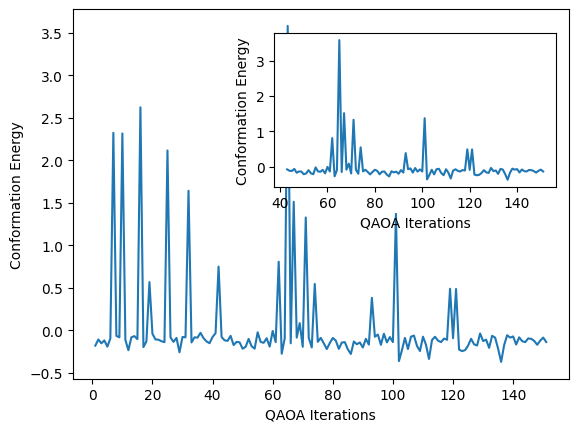

In [13]:
import matplotlib.pyplot as plt

fig = plt.figure()

plt.plot(counts, values)
plt.ylabel("Conformation Energy")
plt.xlabel("QAOA Iterations")

fig.add_axes([0.44, 0.51, 0.44, 0.32])

plt.plot(counts[132:], values[132:])
plt.ylabel("Conformation Energy")
plt.xlabel("QAOA Iterations")
plt.show()

In [14]:
result = protein_folding_problem.interpret(raw_result=raw_result)
print(
    "The bitstring representing the shape of the protein during optimization is: ",
    result.turn_sequence,
)
print("The expanded expression is:", result.get_result_binary_vector())

The bitstring representing the shape of the protein during optimization is:  001010101
The expanded expression is: 0______0_____________________________________________________________________________________________________________________________101010_1____


In [15]:
print(
    f"The folded protein's main sequence of turns is: {result.protein_shape_decoder.main_turns}"
)
print(f"and the side turn sequences are: {result.protein_shape_decoder.side_turns}")

The folded protein's main sequence of turns is: [1, 0, 3, 1, 1, 1]
and the side turn sequences are: [None, None, None, None, None, None, None]


In [16]:
print(result.protein_shape_file_gen.get_xyz_data())

[['A' '0.0' '0.0' '0.0']
 ['P' '0.5773502691896258' '0.5773502691896258' '-0.5773502691896258']
 ['R' '1.1547005383792517' '0.0' '-1.1547005383792517']
 ['L' '1.7320508075688776' '-0.5773502691896258' '-0.5773502691896258']
 ['R' '1.154700538379252' '-1.1547005383792517' '0.0']
 ['F' '1.7320508075688776' '-0.5773502691896258' '-0.5773502691896258']
 ['Y' '1.154700538379252' '-1.1547005383792517' '0.0']]


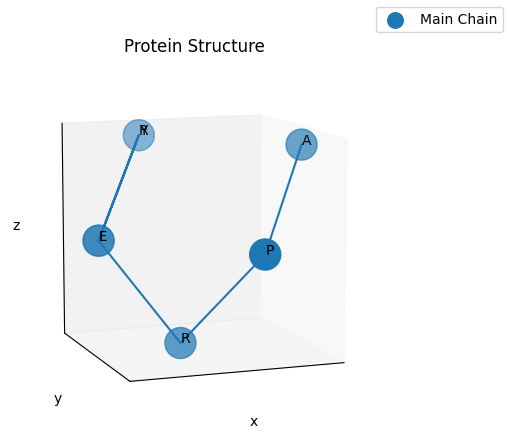

In [17]:
fig = result.get_figure(title="Protein Structure", ticks=False, grid=True)
fig.get_axes()[0].view_init(10, 70)

In [18]:
peptide = Peptide("APRLR", ["", "", "F", "Y", ""])
protein_folding_problem = ProteinFoldingProblem(peptide, mj_interaction, penalty_terms)
qubit_op = protein_folding_problem.qubit_op()

# set classical optimizer
optimizer = SPSA(maxiter=50)
reps=2

counts = []
values = []


def store_intermediate_result(eval_count, parameters, mean, std):
    counts.append(eval_count)
    values.append(mean)

# Initialize QAOA with the callback function
qaoa = QAOA(
    reps=reps,
    sampler=Sampler(session=backend),
    optimizer=optimizer,
    initial_point=np.random.random(2*reps),
    aggregation = 0.1,
    callback=store_intermediate_result,
)

raw_result = qaoa.compute_minimum_eigenvalue(qubit_op)
result_2 = protein_folding_problem.interpret(raw_result=raw_result)

In [19]:
print(raw_result)

SamplingMinimumEigensolverResult:
	Eigenvalue: 3.175000000000001
	Best measurement
: {'state': 13, 'bitstring': '0001101', 'value': 0j, 'probability': 0.056}



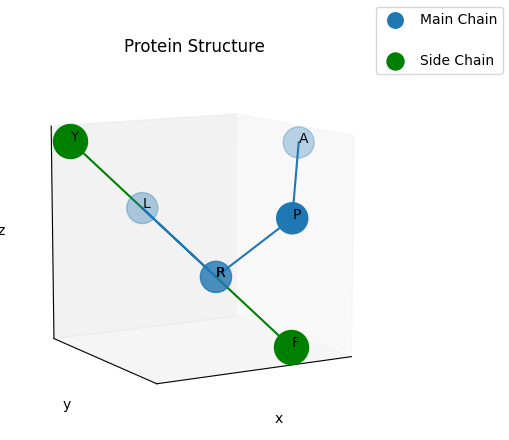

In [20]:
fig = result_2.get_figure(title="Protein Structure", ticks=False, grid=True)
fig.get_axes()[0].view_init(10, 60)

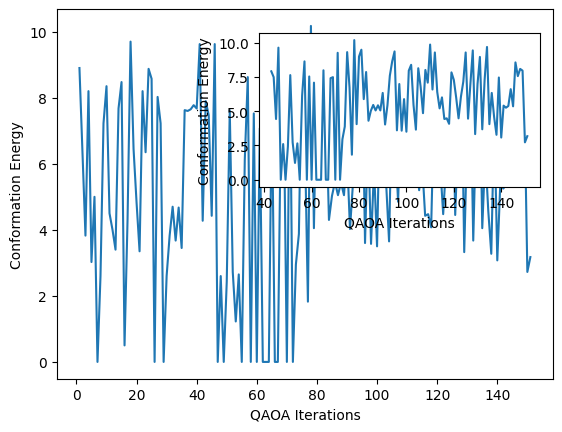

In [21]:
import matplotlib.pyplot as plt

fig = plt.figure()

plt.plot(counts, values)
plt.ylabel("Conformation Energy")
plt.xlabel("QAOA Iterations")

fig.add_axes([0.44, 0.51, 0.44, 0.32])

plt.plot(counts[42:], values[42:])
plt.ylabel("Conformation Energy")
plt.xlabel("QAOA Iterations")
plt.show()